In [3]:
cd /home/kingsman/Escritorio/PhD/Main/Lenstronomy

/home/kingsman/Escritorio/PhD/Main/Lenstronomy


/home/kingsman/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (10, 40, 40, 3)
images_clean shape: (10, 40, 40, 3)
delta_psi_maps shape: (10, 40, 40)
subhalo_mass shape: (10,)
subhalo_x shape: (10,)
subhalo_y shape: (10,)
Plotting samples: [5 8 1]


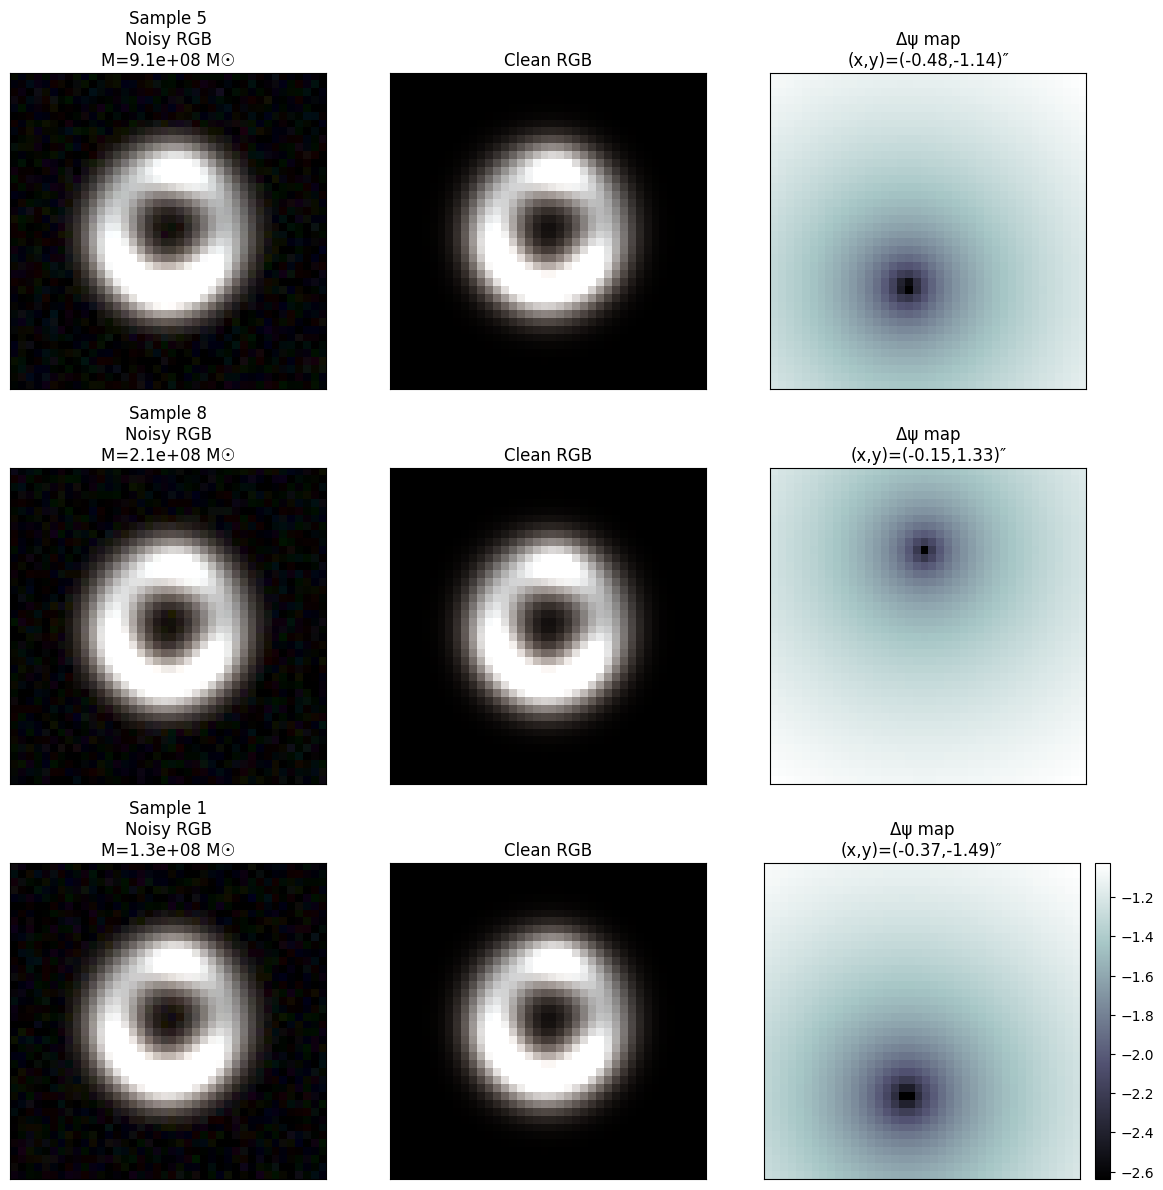

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to the new RGB HDF5 dataset
h5_path = 'lens_dataset_lsst_rgb.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
